In [5]:
# import needed libraries.
import pandas as pd
import geopandas as gpd # geographic data manipulation
import numpy as np

import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation

#this is for the heatmap.
import folium
from folium.plugins import HeatMap

from google.colab import drive #to mount google drive to the vm
import shutil

import os
!pip install python-dotenv
from dotenv import load_dotenv
import requests
import time


In [6]:
# Load the .env file
load_dotenv('/content/.env')
# Mount Google Drive (need to be run only once! and is valid when working on Google Colab)
# drive.mount('/content/drive')

True

In [ ]:
# download the dataset from google drive.
# Download the file from Google Drive using the file ID
!gdown {os.getenv('billboards-data-sectors')}
!gdown {os.getenv('taxi-geojason')}


In [8]:
#load csv file into a pandas dataframe
df = pd.read_csv("/content/billboard_data_sectors.csv")

In [9]:
#show a sample of the data
df.tail()

,borough,house__,street_name,block,lot,bin__,community___board,sign_illumination,sign_type,sign_height_roof,sign_height_curb,sign_weight,sign_sq_footage,sign_near_park,sign_dist_from_highway,sign_dist_from_park,text_on_sign,sign_near_highway,landmarked,sector
5470,MANHATTAN,14,MURRAY STREET,124,7,1001400,101,Y,WALL,0,144,0,33,N,0,0,THE UPS STORE(LOGO) ...,NaN,NaN,"General store, department store, mall"
5471,MANHATTAN,1540,BROADWAY,998,7501,1076844,105,Y,WALL,0,182,0,35,N,0,0,U.S. POLO ASSN. SINCE 1890 ...,NaN,NaN,Others
5472,MANHATTAN,1290,AVENUE OF THE AMERICAS,1267,1,1034510,105,NaN,WALL,0,144,0,9,N,0,0,OPEN 7 DAYS ...,NaN,NaN,Others
5473,MANHATTAN,35,W43 ST,1259,117,1034216,105,NaN,WALL,0,360,0,12,N,0,0,CITI CAFE COFFEE SANDWICH SALAD HOT ENTREE BU...,NaN,NaN,"Food, beverages"
5474,MANHATTAN,333,EAST 56 STREET,1349,14,1039984,106,Y,WALL,0,135,0,18,N,0,0,PARK ...,NaN,NaN,Recreation and parks


In [10]:
#number of rows and cols
df.shape

(5475, 20)

In [11]:
#check the data types
df.dtypes

borough                   object
house__                   object
street_name               object
block                      int64
lot                        int64
bin__                      int64
community___board          int64
sign_illumination         object
sign_type                 object
sign_height_roof           int64
sign_height_curb           int64
sign_weight                int64
sign_sq_footage            int64
sign_near_park            object
sign_dist_from_highway     int64
sign_dist_from_park        int64
text_on_sign              object
sign_near_highway         object
landmarked                object
sector                    object
dtype: object

In [12]:
#rename columns
df.rename(columns={'house__':'house', 'bin__':'bin', 'community___board':'community_board'}, inplace=True)

In [13]:
#create a Latitude and Longitude columns
df['Latitude'] = pd.NA
df['Longitude'] = pd.NA
df['zone_id'] = pd.NA

In [14]:
#check the data types
df.dtypes

borough                   object
house                     object
street_name               object
block                      int64
lot                        int64
bin                        int64
community_board            int64
sign_illumination         object
sign_type                 object
sign_height_roof           int64
sign_height_curb           int64
sign_weight                int64
sign_sq_footage            int64
sign_near_park            object
sign_dist_from_highway     int64
sign_dist_from_park        int64
text_on_sign              object
sign_near_highway         object
landmarked                object
sector                    object
Latitude                  object
Longitude                 object
zone_id                   object
dtype: object

In [ ]:
def find_address_candidates(single_line, token):
    base_url = "https://locatenyc.io/arcgis/rest/services/locateNYC/v1/GeocodeServer/findAddressCandidates/"

    params = {
        "singleLine": single_line,
        "token": token
    }

    response = requests.get(base_url, params=params)

    if response.status_code == 200:
        address_candidates = response.json()
        return address_candidates
    else:
        return f"Error: {response.status_code}"

def update_lat_long(df, token):
    total_rows = len(df)
    last_reported_percentage = 0

    for index, row in df.iterrows():
        if pd.notna(row['Latitude']) and pd.notna(row['Longitude']):
            print(f"Row {index + 1} already has coordinates: Latitude {row['Latitude']}, Longitude {row['Longitude']}")
            continue

        single_line_address = None

        # Determine the single line address to use
        if pd.notna(row['house']) and pd.notna(row['street_name']):
            single_line_address = f"{row['house']} {row['street_name']}"
        elif pd.notna(row['bin']):
            single_line_address = row['bin']
        # elif pd.notna(row['house']) and pd.notna(row['street_name']):
        #     single_line_address = f"{row['house']} {row['street_name']}"

        if single_line_address:
            response = find_address_candidates(single_line_address, token)
            if isinstance(response, dict):
                if 'candidates' in response and len(response['candidates']) > 0:
                    best_candidate = response['candidates'][0]
                    df.at[index, 'Latitude'] = best_candidate['location']['y']
                    df.at[index, 'Longitude'] = best_candidate['location']['x']
                else:
                    print(f"Row {index + 1}: No candidates found for address '{single_line_address}'")
            else:
                print(f"Row {index + 1}: API returned error: {response}")

        # Log the percentage of processed rows every 1%
        processed_percentage = (index + 1) / total_rows * 100
        if int(processed_percentage) > last_reported_percentage:
            last_reported_percentage = int(processed_percentage)
            print(f"Processed {last_reported_percentage}% of rows")


        time.sleep(0.05)

    return df

api_token = os.getenv('locate_ny_token')
updated_df = update_lat_long(df, api_token)



In [17]:
updated_df.head()

,borough,house,street_name,block,lot,bin,community_board,sign_illumination,sign_type,sign_height_roof,...,sign_near_park,sign_dist_from_highway,sign_dist_from_park,text_on_sign,sign_near_highway,landmarked,sector,Latitude,Longitude,zone_id
0,MANHATTAN,183,BROADWAY,63,16,1001074,101,NaN,WALL,0,...,N,0,0,ROUND LOGO AND SUNGLASS HUT ...,NaN,NaN,Others,40.710119,-74.009735,<NA>
1,MANHATTAN,1313,BROADWAY,810,40,1015220,105,NaN,WALL,0,...,N,0,0,...,NaN,NaN,Others,40.750131,-73.988129,<NA>
2,MANHATTAN,85,10TH AVENUE,687,29,1012277,104,Y,WALL,0,...,N,0,0,L'ATELIER DE JOEL ROBUCHON ...,NaN,NaN,"Food, beverages",40.743385,-74.007983,<NA>
3,MANHATTAN,85,10TH AVENUE,687,29,1012277,104,Y,WALL,0,...,N,0,0,L'ATELIER DE JOEL ROBUCHON ...,NaN,NaN,"Food, beverages",40.743385,-74.007983,<NA>
4,MANHATTAN,773,MADISON AVENUE,1381,7502,1076285,108,Y,WALL,0,...,N,0,0,KWIAT ...,NaN,Y,Others,40.76804,-73.967801,<NA>


In [20]:
#count missing or nan rows in the Latitude in the updated df
updated_df['Latitude'].isna().sum()

7

In [21]:
updated_df.shape

(5475, 23)

In [22]:
#drop rows with missing Latitude in the updated df
updated_df = updated_df.dropna(subset=['Latitude'])

In [23]:
updated_df.shape

(5468, 23)

In [24]:
#assign taxi zones to subway locations.
# Load GeoJSON data into a GeoDataFrame
def load_geojson_gpd(filepath):
    return gpd.read_file(filepath)

# Function to find zones using spatial join in geopandas
def assign_zones(df, gdf):
    # Convert DataFrame to GeoDataFrame
    gdf_points = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
    gdf_points.set_crs(gdf.crs, inplace=True)  # Ensure CRS matches if known; otherwise, assume it matches

    # Spatial join points to polygons
    joined = gpd.sjoin(gdf_points, gdf, how="left", op='within')
    return joined['location_id']

# Load GeoJSON data into a GeoDataFrame
geo_df = load_geojson_gpd('/content/NYC Taxi Zones.geojson')

# Assign zones using the efficient spatial join
updated_df['zone_id'] = assign_zones(updated_df, geo_df)

updated_df.head()

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-24-3ee5f1019ed8>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  updated_df['zone_id'] = assign_zones(updated_df, geo_df)


,borough,house,street_name,block,lot,bin,community_board,sign_illumination,sign_type,sign_height_roof,...,sign_near_park,sign_dist_from_highway,sign_dist_from_park,text_on_sign,sign_near_highway,landmarked,sector,Latitude,Longitude,zone_id
0,MANHATTAN,183,BROADWAY,63,16,1001074,101,NaN,WALL,0,...,N,0,0,ROUND LOGO AND SUNGLASS HUT ...,NaN,NaN,Others,40.710119,-74.009735,261
1,MANHATTAN,1313,BROADWAY,810,40,1015220,105,NaN,WALL,0,...,N,0,0,...,NaN,NaN,Others,40.750131,-73.988129,100
2,MANHATTAN,85,10TH AVENUE,687,29,1012277,104,Y,WALL,0,...,N,0,0,L'ATELIER DE JOEL ROBUCHON ...,NaN,NaN,"Food, beverages",40.743385,-74.007983,246
3,MANHATTAN,85,10TH AVENUE,687,29,1012277,104,Y,WALL,0,...,N,0,0,L'ATELIER DE JOEL ROBUCHON ...,NaN,NaN,"Food, beverages",40.743385,-74.007983,246
4,MANHATTAN,773,MADISON AVENUE,1381,7502,1076285,108,Y,WALL,0,...,N,0,0,KWIAT ...,NaN,Y,Others,40.76804,-73.967801,237


In [25]:
unique_zones = [  4,  13,  24,  41,  42,  43,  45,  48,  50,  68,  74,  75,  79,
        87,  88,  90, 100, 107, 113, 114, 116, 125, 137, 140, 141, 142,
       143, 144, 148, 151, 152, 158, 161, 162, 163, 164, 166, 170, 186,
       211, 224, 229, 230, 231, 232, 233, 234, 236, 237, 238, 239, 244,
       246, 249, 261, 262, 263, 127, 128, 202, 209, 243,  12, 153, 194,
       120, 105]

unique_zones_str = [str(zone) for zone in unique_zones]

#drop all rows in the df for which the zone_id is not in the unique_zones
updated_df = updated_df[updated_df['zone_id'].isin(unique_zones_str)]

In [26]:
updated_df.shape

(5462, 23)

In [42]:
updated_df.dtypes

borough                   object
house                     object
street_name               object
block                      int64
lot                        int64
bin                        int64
community_board            int64
sign_illumination         object
sign_type                 object
sign_height_roof           int64
sign_height_curb           int64
sign_weight                int64
sign_sq_footage            int64
sign_near_park            object
sign_dist_from_highway     int64
sign_dist_from_park        int64
text_on_sign              object
sign_near_highway         object
landmarked                object
sector                    object
Latitude                  object
Longitude                 object
zone_id                   object
dtype: object

In [55]:
updated_df['text_on_sign'] = updated_df['text_on_sign'].apply(lambda x: np.nan if pd.isna(x) or pd.Series(x).str.replace(r'\s+', '', regex=True).iloc[0] == '' else x)


In [63]:
#count the number of missing values in the text_on_sign
updated_df['text_on_sign'].isna().sum()

402

In [60]:
#export updated df to csv
updated_df.to_csv('billboard_data_with_coords_and_zones.csv', index=False)

In [59]:
updated_df.shape

(5462, 23)

In [65]:
# Separate the rows into two DataFrames
no_text_df = updated_df[updated_df['text_on_sign'].isna()]
with_text_df = updated_df[updated_df['text_on_sign'].notna()]

In [66]:
no_text_df.shape

(402, 23)

In [67]:
#export to csv
no_text_df.to_csv('no_text_df.csv', index=False)
with_text_df.to_csv('with_text_df.csv', index=False)

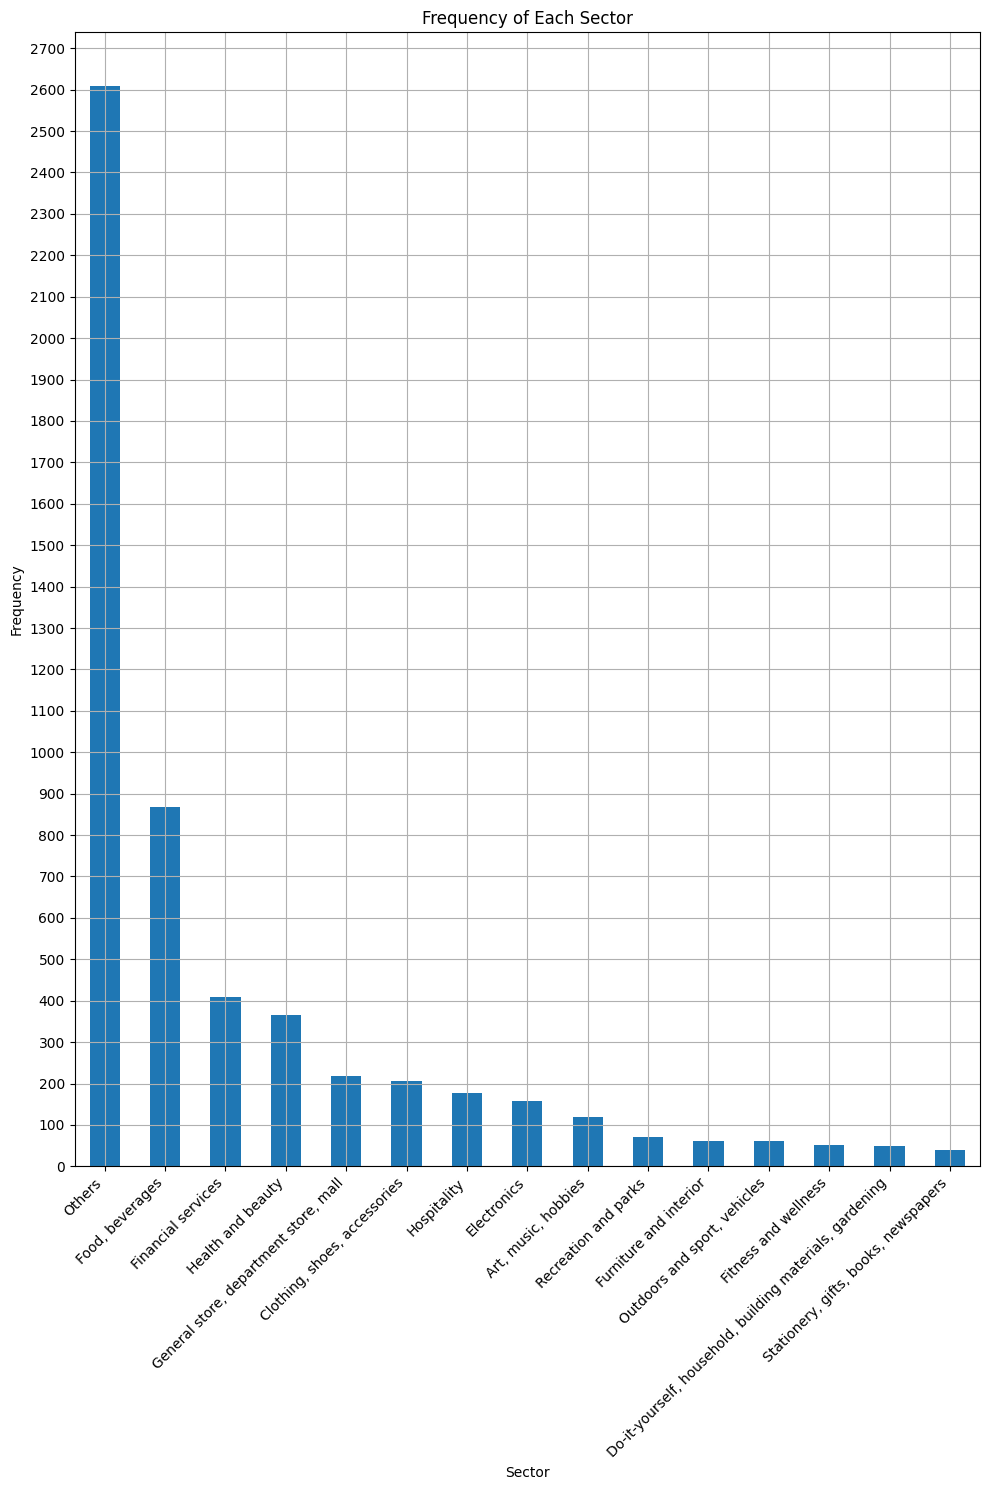

In [78]:
# Calculate the frequency of each sector
sector_counts = updated_df['sector'].value_counts()

# Plot the frequency of each sector
plt.figure(figsize=(10, 15))
sector_counts.plot(kind='bar')
plt.title('Frequency of Each Sector')
plt.xlabel('Sector')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True)
max_freq = sector_counts.max()

plt.yticks(range(0, max_freq + 100, 100))
plt.show()

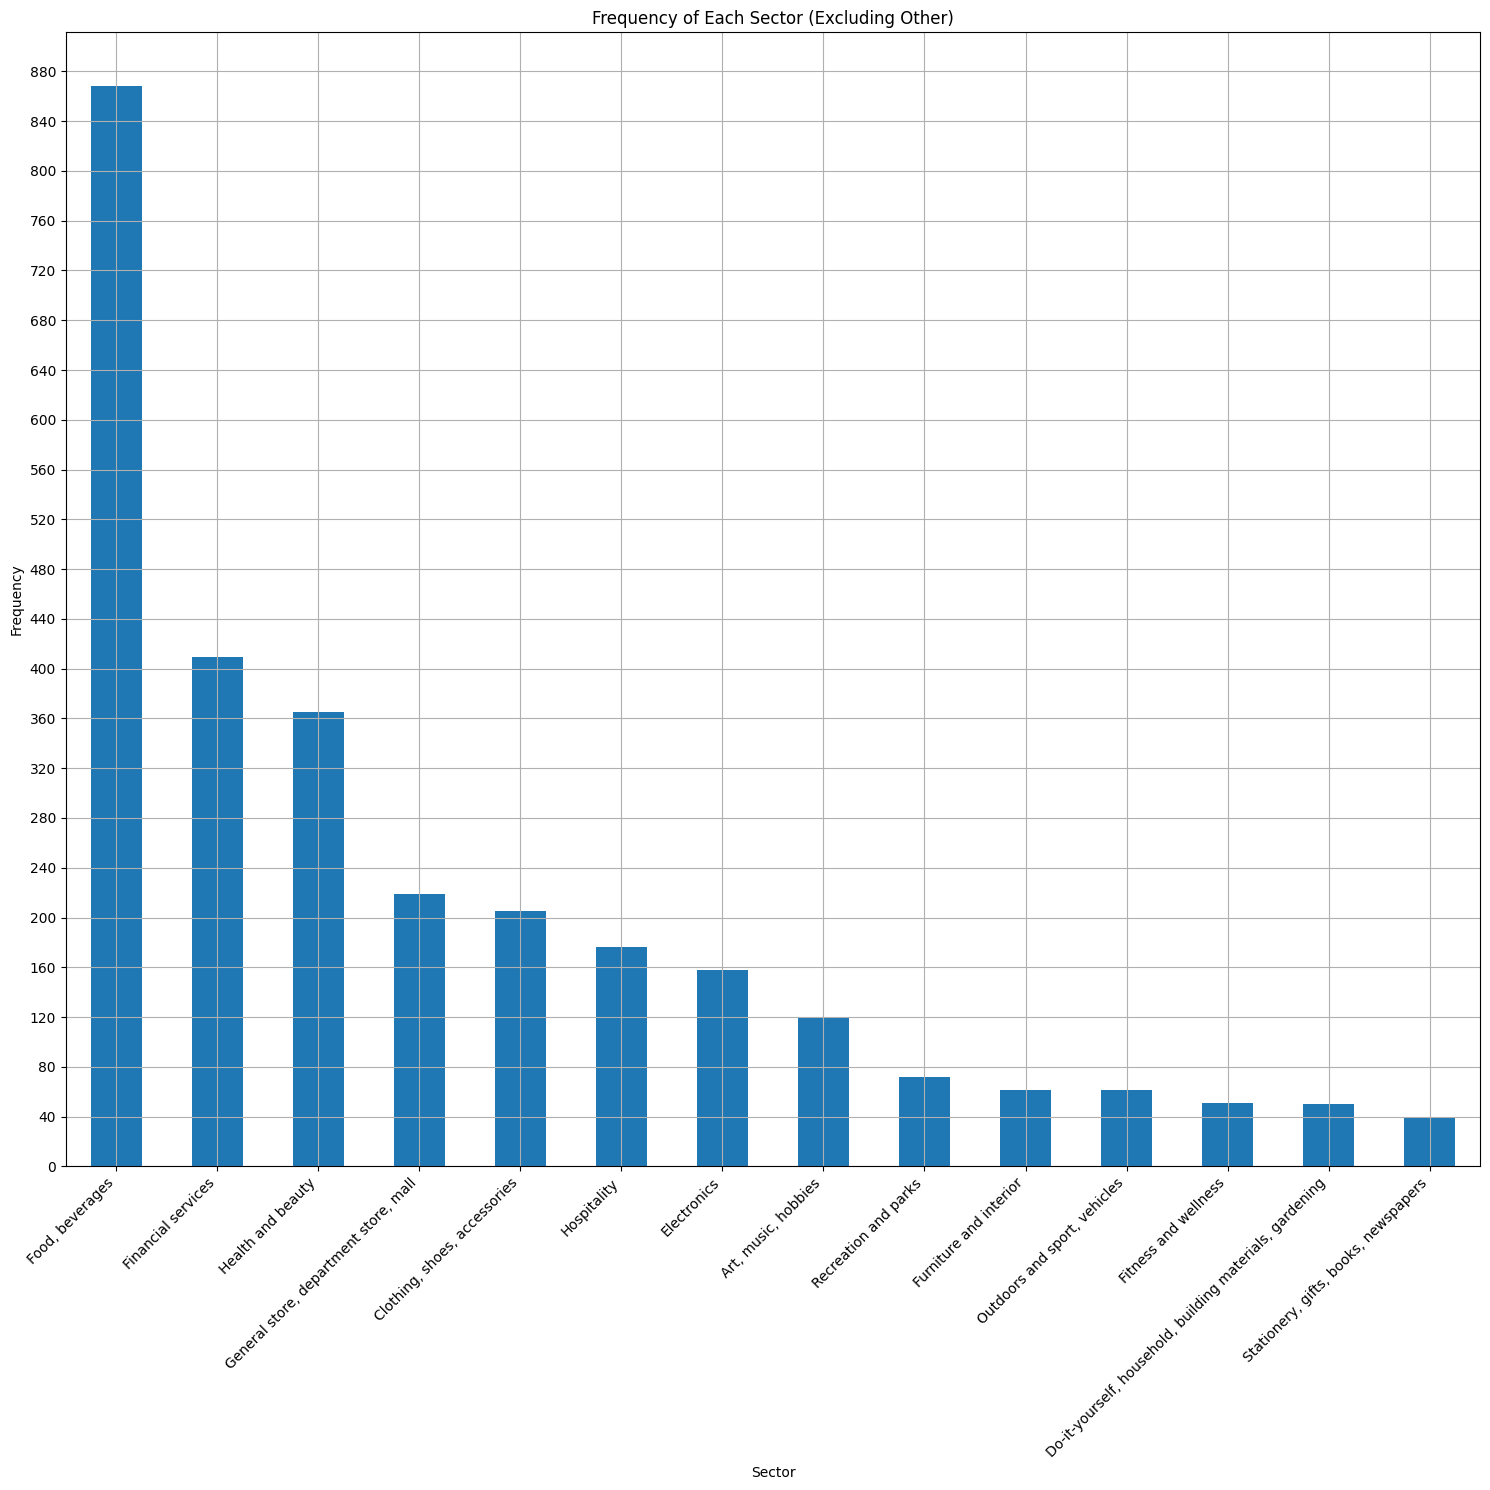

In [76]:
# Filter out the "Other" sector
filtered_df = updated_df[updated_df['sector'] != 'Others']

# Calculate the frequency of each sector
sector_counts = filtered_df['sector'].value_counts()

# Plot the frequency of each sector
plt.figure(figsize=(15, 15))
sector_counts.plot(kind='bar')
plt.title('Frequency of Each Sector (Excluding Other)')
plt.xlabel('Sector')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True)
max_freq = sector_counts.max()

plt.yticks(range(0, max_freq + 40, 40))
plt.show()


In [79]:
#return unqique sectors
updated_df['sector'].unique()

array(['Others', 'Food, beverages', 'Fitness and wellness',
       'Furniture and interior', 'Electronics', 'Art, music, hobbies',
       'Financial services', 'Stationery, gifts, books, newspapers',
       'General store, department store, mall',
       'Do-it-yourself, household, building materials, gardening',
       'Health and beauty', 'Clothing, shoes, accessories',
       'Outdoors and sport, vehicles', 'Hospitality',
       'Recreation and parks'], dtype=object)